In [147]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
import os
import glob
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import neighbors
from sklearn import datasets, linear_model, metrics

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearnex import patch_sklearn

pd.set_option('display.max_colwidth', None)

np.random.seed(0)

In [148]:
# Params
params = {'learning_rate': 0.2,
          'n_estimators': 500,
          'min_samples_split': 5,
          'max_depth': 5}

patch_sklearn()

def convert(df: pd.DataFrame, frame_size=10):
    x = np.asarray(df.iloc[:, 1]).reshape(-1, frame_size)
#     x = x[x.shape[0]//10:-x.shape[0]//10]
    return x

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [149]:
data_dir = Path("./1m") 
df1 = pd.read_csv(data_dir / "fft_100_0_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()
df1 = convert(df1)

data_dir = Path("./SideVent") 
df2 = pd.read_csv(data_dir / "fft_100_0_SideVent_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2.dropna()
df25 = pd.read_csv(data_dir / "fft_0_0_SideVent_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df25 = df25[df25['frequency'] != "clocktime"]
df25 = df25.dropna()
df2 = df2.append([df25])
df2 = convert(df2)

data_dir = Path("./NoAir-Data") 
df3 = pd.read_csv(data_dir / "fft_NOAIR1.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = df3.dropna()
df3 = convert(df3)

df4 = pd.read_csv(data_dir / "fft_NOAIR2.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df4 = df4[df4['frequency'] != "clocktime"]
df4 = df4.dropna()
df4 = convert(df4)

print(df3[:,9].max(), df4[:,9].max())

# i = 0
# while i < df3.shape[0]:
#     if df3[i,9] > 3.0:
#         df3 = np.delete(df3, i, axis = 0)
#     else:
#         i += 1

# print(df3[:,9].max(), df4[:,9].max())

# i = 0
# while i < df4.shape[0]:
#     if df4[i,9] > 3.0:
#         df4 = np.delete(df4, i, axis = 0)
#     else:
#         i += 1
    
# df3_final = df3
# df4_final = df4
        
print(df3[:,9].max(), df4[:,9].max())

3.98 5.45
3.98 5.45


In [150]:
def indices(df):
#     return np.random.choice(df.shape[0], size=2000, replace=False, p=None)
    return df[4000:24000]

ones = np.ones(20000).reshape(-1, 1)
zeroes = np.zeros(20000).reshape(-1, 1)

#LABELED DATA W/ AIRFLOW
df1 = np.append(indices(df1), ones, 1)
df2 = np.append(df2[:20000], ones, 1)

#LABELED DATA W/OUT AIRFLOW
df3 = np.append(indices(df3_final), zeroes, 1)
df4 = np.append(indices(df4_final), zeroes, 1)

print(df3)

[[ 20.      37.0014  10.4319 ...  12.       2.63     0.    ]
 [ 84.      34.4554  33.0229 ...   4.       2.63     0.    ]
 [ 24.      19.4295   9.4184 ...  24.       2.69     0.    ]
 ...
 [ 70.      33.189    3.2811 ...   6.       2.88     0.    ]
 [114.      27.0607  14.9056 ...   2.       2.69     0.    ]
 [ 36.      52.6706  18.8347 ...   4.       2.82     0.    ]]


In [151]:
df = np.concatenate([df1, df2, df3, df4], axis=0)
#df = df1.append([df4])

# New change
np.random.shuffle(df)
print(df.shape)

(80000, 11)


In [152]:
data = df

In [153]:
X = data[:,:-1]

X = X[:, :9]
X.shape

(80000, 9)

In [154]:
X

array([[ 42.    ,  49.762 ,  24.1283, ...,  28.0325,   2.8087,  54.    ],
       [106.    , 113.6952,  55.9758, ...,   3.2723,  25.8203,  26.    ],
       [700.    , 745.5685, 113.6638, ...,  51.774 ,  60.727 ,  64.    ],
       ...,
       [206.    ,  88.8574,  18.1805, ...,  30.6834,  28.2549,   2.    ],
       [ 30.    ,  64.7165,  17.4715, ...,  14.6542,  17.3635,   2.    ],
       [  6.    ,  10.7289,   8.1626, ...,   4.623 ,   4.7782,   2.    ]])

In [155]:
y = data[:, -1]
y.shape


(80000,)

In [156]:
y

array([1., 1., 1., ..., 0., 0., 0.])

In [157]:
print (X.shape, y.shape)

(80000, 9) (80000,)


In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [159]:
clf = GradientBoostingClassifier(**params)
clf.fit(X_train, y_train.ravel())

print('Accuracy from sk-learn: {0}'.format(clf.score(X_test, y_test)))


Accuracy from sk-learn: 0.96225


In [160]:
y_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

In [161]:
print(y_pred[:5])
print(y_test[:5])

[0. 1. 1. 1. 0.]
[0. 1. 1. 1. 0.]


In [162]:
print(y_train_pred[:5])
print(y_train[:5])

[1. 0. 0. 1. 1.]
[1. 0. 0. 1. 1.]


In [163]:
print("Test score: ", clf.score(X_test, y_test))

Test score:  0.96225


In [164]:
print("Train score: ", clf.score(X_train, y_train))

Train score:  0.997546875


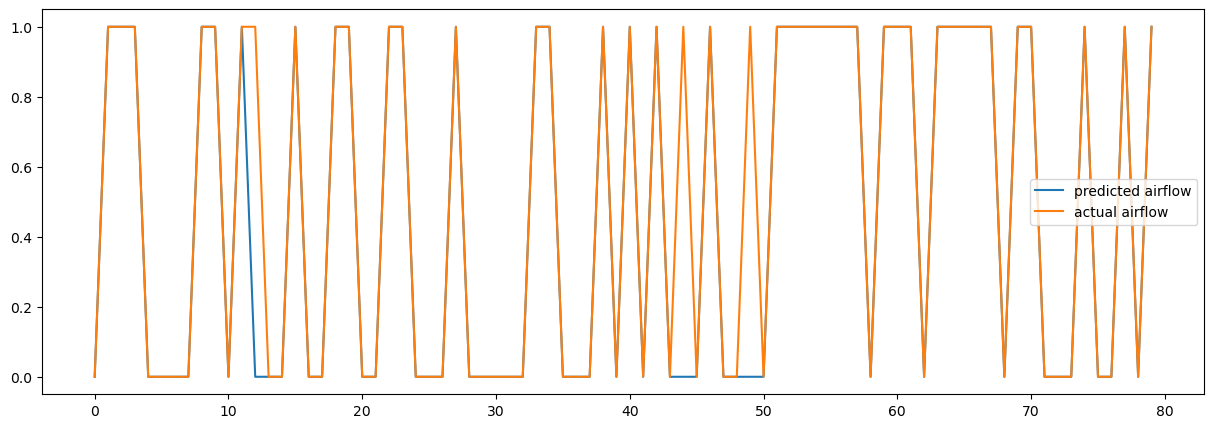

In [165]:
predictions = clf.predict(X_test[:80])
plt.figure(figsize=(15,5))
plt.plot(predictions, label = "predicted airflow")
plt.plot(y_test[:80], label = "actual airflow")
plt.legend()
plt.show()

In [244]:
from joblib import dump,load

dump(clf, 'flowClassifer.joblib')
#reg = load('PHONE1flowSense.joblib')

['PHONE1flowSense1.joblib']

Mean Squared Error:  156.22358225167554


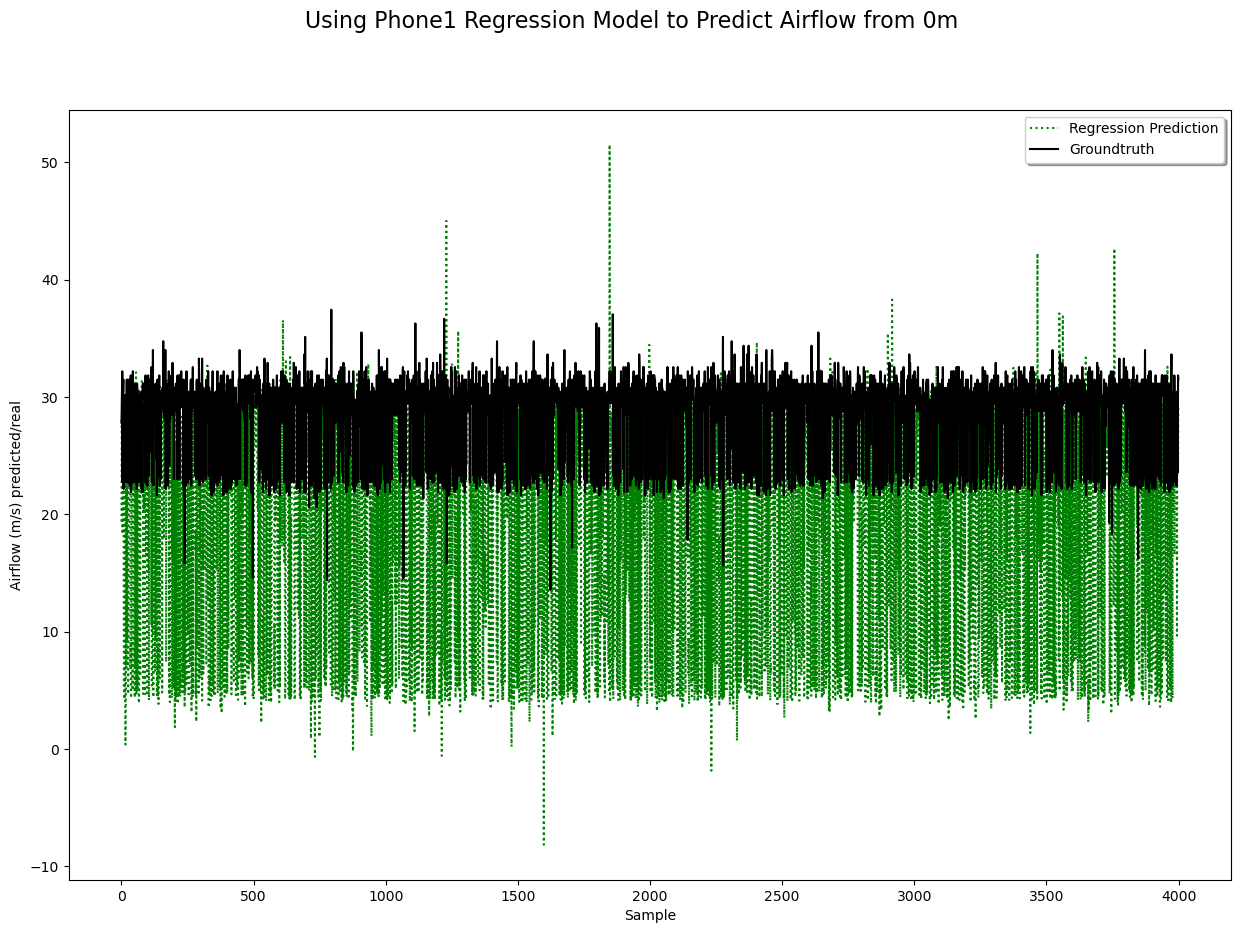

In [290]:
#Looking at predictions from SideVent 0m
data_dir = Path("./SideVent") 
df10 = pd.read_csv(data_dir / "fft_0_0_SideVent_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df10 = df10[df10['frequency'] != "clocktime"]
df10 = df10.dropna()

df11 = pd.read_csv(data_dir / "fft_100_0_SideVent_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df11 = df11[df11['frequency'] != "clocktime"]
df11 = df11.dropna()

df = df10.append([df11])
df = convert(df)

indices = np.random.choice(np.arange(df.shape[0]), size=4000, replace=False, p=None)
    
X = df[:,:-1]
X = X[indices, :9]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from 0m', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()


Mean Squared Error:  175.66536590888893


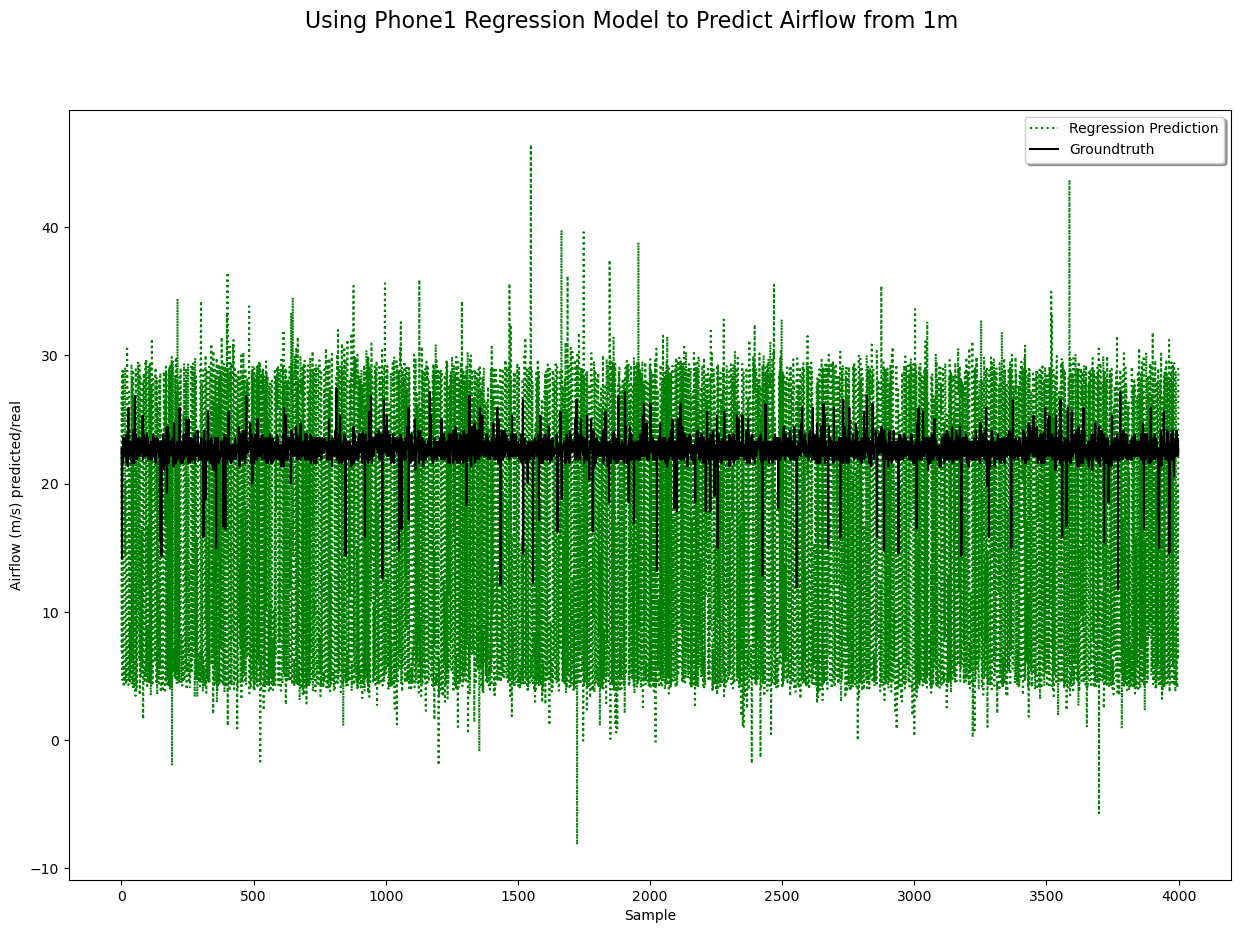

In [246]:
#Looking at predictions from SideVent 1m
data_dir = Path("./SideVent") 
df10 = pd.read_csv(data_dir / "fft_100_0_SideVent_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df10 = df10[df10['frequency'] != "clocktime"]
df10 = df10.dropna()
df = convert(df10)

indices = np.random.choice(np.arange(df.shape[0]), size=4000, replace=False, p=None)
    
X = df[:,:-1]
X = X[indices, :9]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from 1m', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

In [339]:
MSE_scores05 = []
MSE_scores10 = []
MSE_scores15 = []
MSE_scores22 = []

Mean Squared Error:  2.1824909853821803


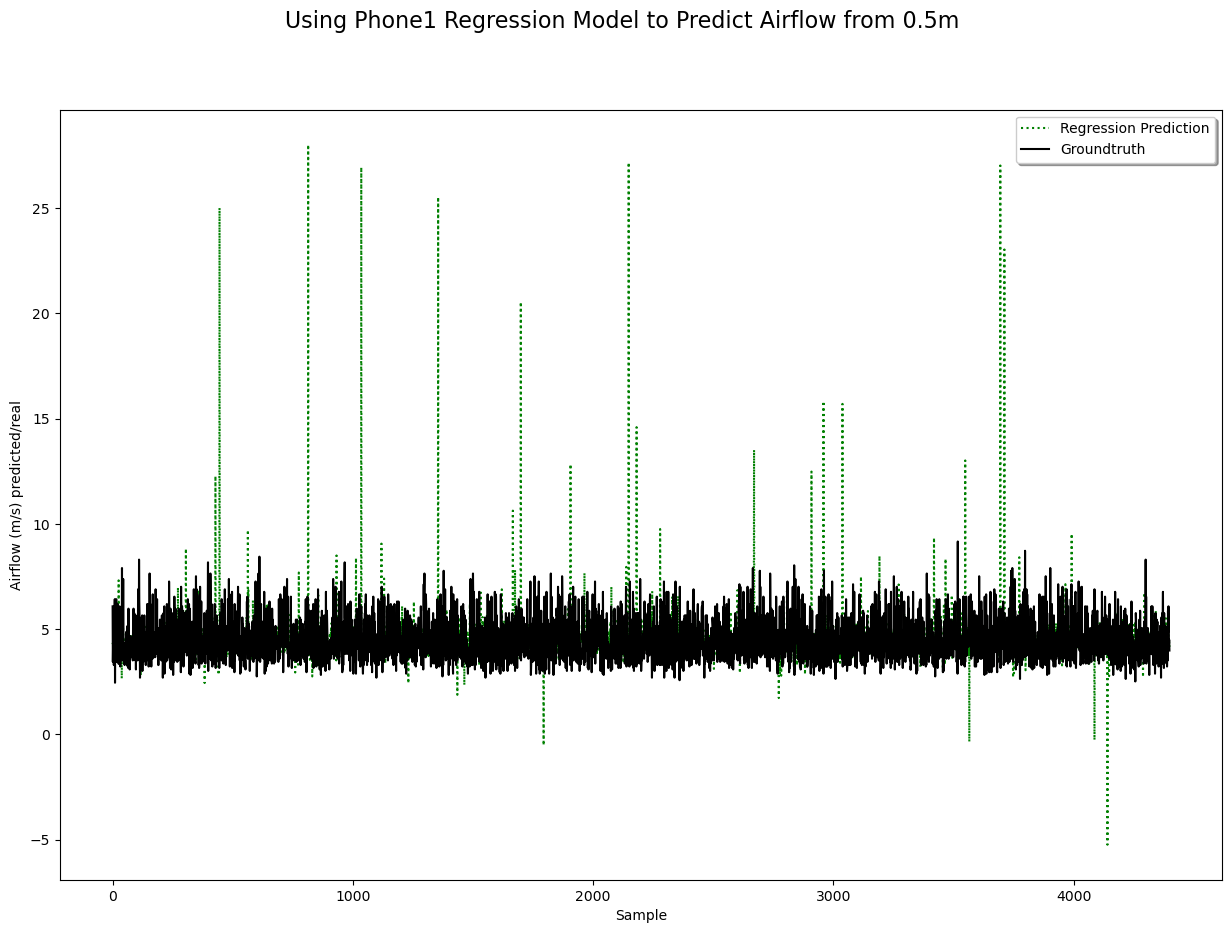

Mean Squared Error:  1.1954258074990953
Mean Squared Error:  1.620512492568968
Mean Squared Error:  1.0002327974591145
Mean Squared Error:  1.2166864003009414
Mean Squared Error:  1.0991362980320951
[1.1954258074990953, 1.620512492568968, 1.0002327974591145, 1.2166864003009414, 1.0991362980320951]


In [340]:
#Looking at predictions from 0.5m
data_dir = Path("./50cm") 
df1 = pd.read_csv(data_dir / "fft_50_0_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()
# df36 = df36[:129*198]

df2 = pd.read_csv(data_dir / "fft_50_180_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2.dropna()

df3 = pd.read_csv(data_dir / "fft_50_90_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = df3.dropna()

df = df3
df = convert(df)

indices = np.random.choice(np.arange(df.shape[0]), size=4400, replace=False, p=None)
    
X = df[:,:-1]
X = X[indices, :9]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from 0.5m', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

for indices in [range(4400), range(4400,8800), range(8800,13200), range(13200, 17600), range(17600, 22000)]:
    X = df[:,:-1]
    X = X[indices, :9]
    X.shape

    y = df[indices, -1]
    y.shape

    print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))
    MSE_scores05.append(mean_squared_error(reg.predict(X), y))
    
print(MSE_scores05)

Mean Squared Error:  1.8100917640790728


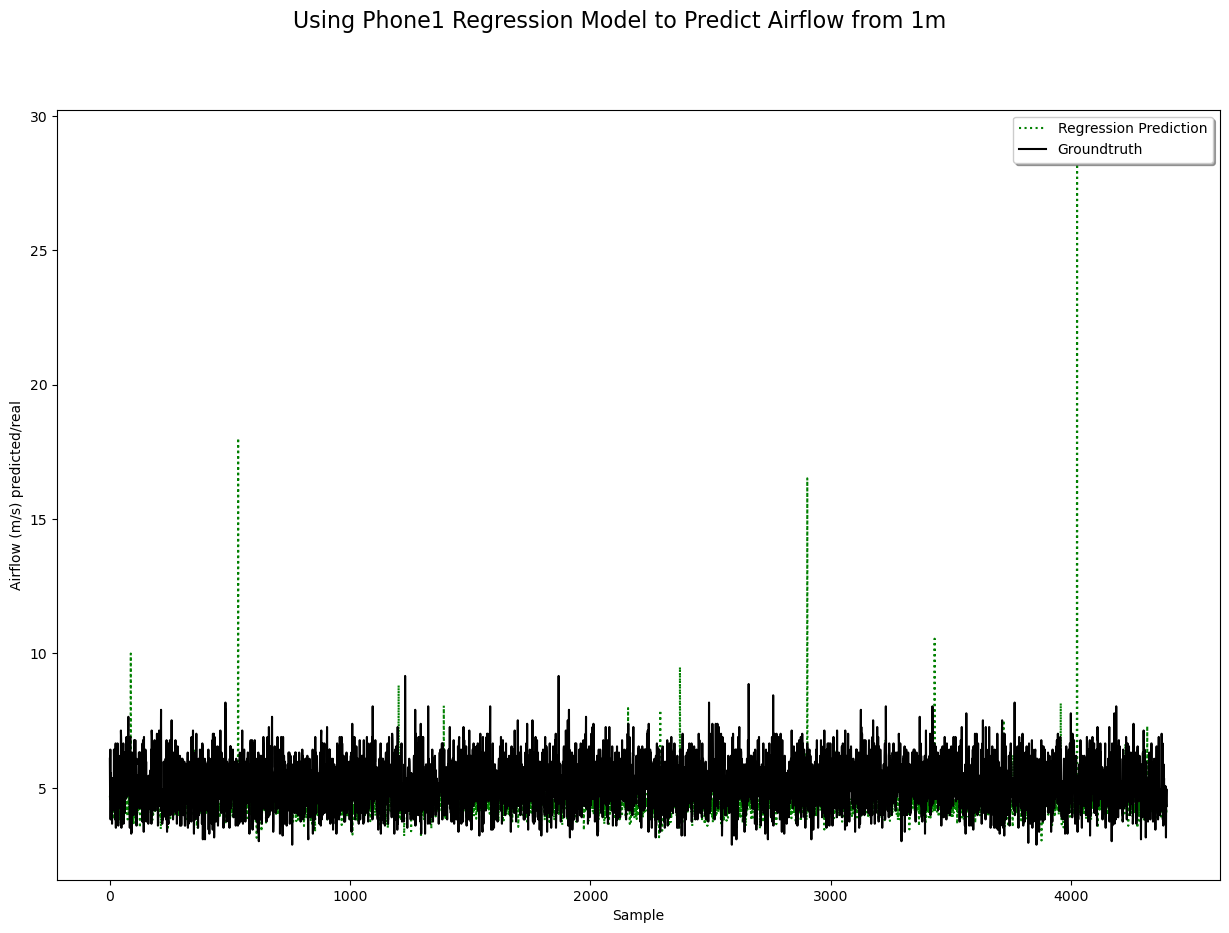

Mean Squared Error:  1.479420826540326
Mean Squared Error:  0.6483809035913358
Mean Squared Error:  0.5838322681528887
Mean Squared Error:  0.6259802848027205
Mean Squared Error:  0.5950247918172028
[1.479420826540326, 0.6483809035913358, 0.5838322681528887, 0.6259802848027205, 0.5950247918172028]


In [341]:
#Looking at predictions from 1m
data_dir = Path("./1m") 
df4 = pd.read_csv(data_dir / "fft_100_0_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df4 = df4[df4['frequency'] != "clocktime"]
df4 = df4.dropna()

df5 = pd.read_csv(data_dir / "fft_100_180_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df5 = df5[df5['frequency'] != "clocktime"]
df5 = df5.dropna()

df6 = pd.read_csv(data_dir / "fft_100_90_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df6 = df6[df6['frequency'] != "clocktime"]
df6 = df6.dropna()

df = df6
df = convert(df)

indices = np.random.choice(np.arange(df.shape[0]), size=4400, replace=False, p=None)
    
X = df[:,:-1]
X = X[indices, :9]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from 1m', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

for indices in [range(4400), range(4400,8800), range(8800,13200), range(13200, 17600), range(17600, 22000)]:
    X = df[:,:-1]
    X = X[indices, :9]
    X.shape

    y = df[indices, -1]
    y.shape

    print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))
    MSE_scores10.append(mean_squared_error(reg.predict(X), y))
    
print(MSE_scores10)

Mean Squared Error:  3.7810868879519455


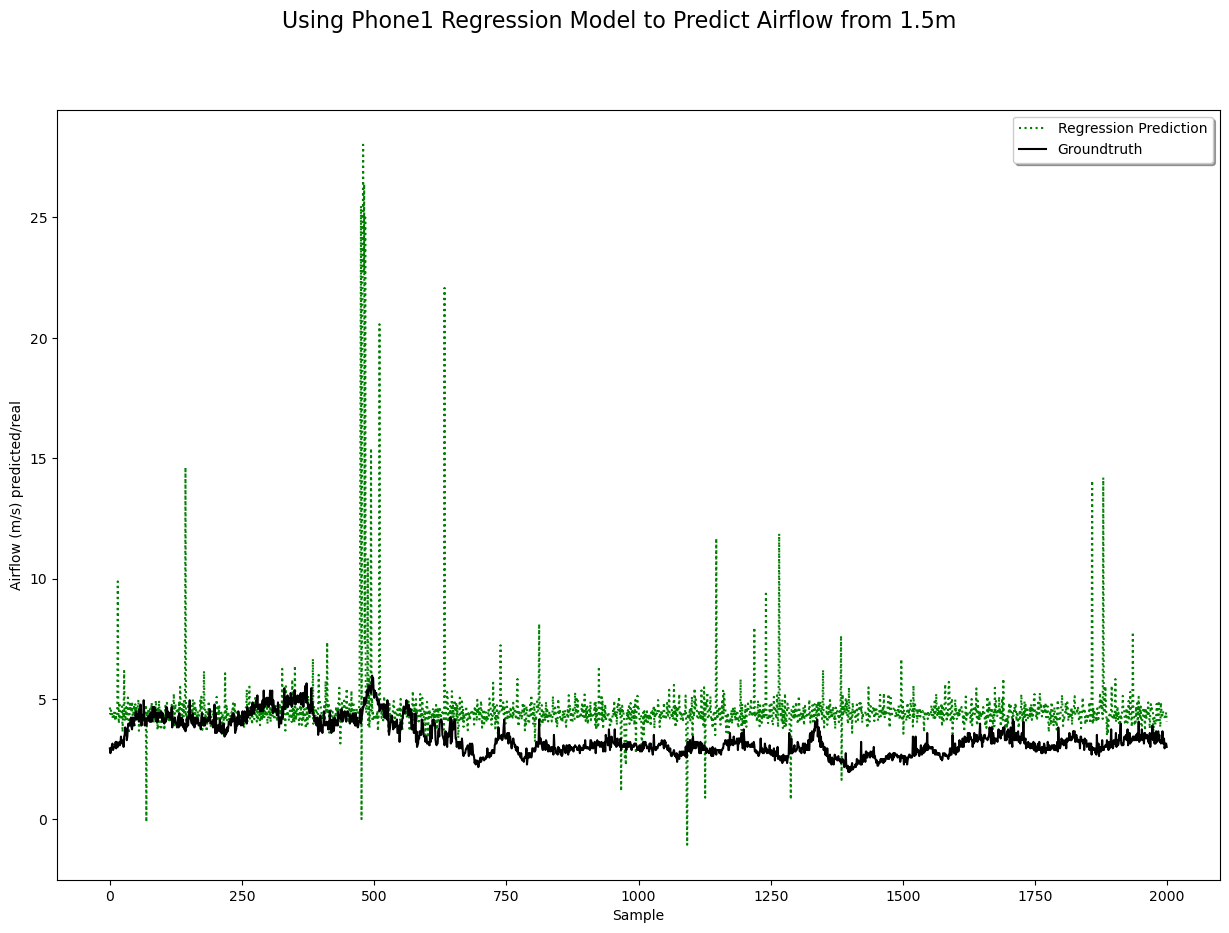

Mean Squared Error:  2.8917497666078185
Mean Squared Error:  0.6139250929461281
Mean Squared Error:  0.6019209722268222
Mean Squared Error:  0.6698064521796848
Mean Squared Error:  0.3337186167109705
[3.7810868879519455, 2.8917497666078185, 0.6139250929461281, 0.6019209722268222, 0.6698064521796848, 0.3337186167109705]


In [342]:
#Looking at predictions from 1.5m
data_dir = Path("./1.5m") 
df7 = pd.read_csv(data_dir / "fft_150_0_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df7 = df7[df7['frequency'] != "clocktime"]
df7 = df7.dropna()

df8 = pd.read_csv(data_dir / "fft_150_90_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df8 = df8[df8['frequency'] != "clocktime"]
df8 = df8.dropna()

df9 = pd.read_csv(data_dir / "fft_150_180_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df9 = df9[df9['frequency'] != "clocktime"]
df9 = df9.dropna()

df = df8
df = convert(df)
df.shape

indices = range(2000)
    
X = df[:,:-1]
X = X[indices, :9]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))
MSE_scores15.append(mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from 1.5m', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

for indices in [range(4400), range(4400,8800), range(8800,13200), range(13200, 17600), range(17600, 22000)]:
    X = df[:,:-1]
    X = X[indices, :9]
    X.shape

    y = df[indices, -1]
    y.shape

    print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))
    MSE_scores15.append(mean_squared_error(reg.predict(X), y))
    
print(MSE_scores15)

Mean Squared Error:  131.4053830870625


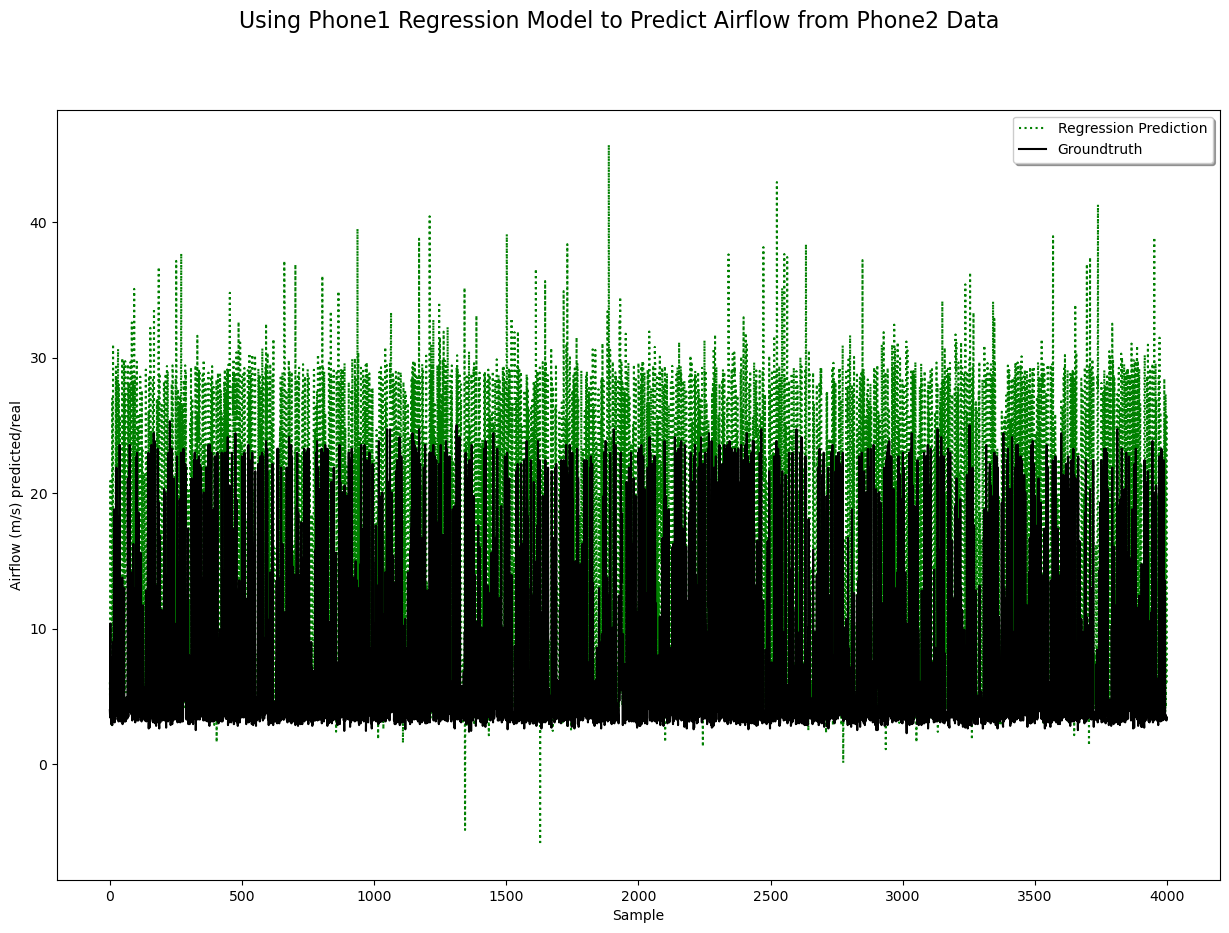

In [285]:
#Looking at predicting values from Phone 2
#PHONE 2 DATA
data_dir = Path("./DiverseDataFromPhone2") 
df11 = pd.read_csv(data_dir / "fft1.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df11 = df11[df11['frequency'] != "clocktime"]
df11 = df11.dropna()

df12 = pd.read_csv(data_dir / "fft2.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df12 = df12[df12['frequency'] != "clocktime"]
df12 = df12.dropna()

df13 = pd.read_csv(data_dir / "fft3.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df13 = df13[df13['frequency'] != "clocktime"]
df13 = df13.dropna()

df14 = pd.read_csv(data_dir / "fft4.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df14 = df14[df14['frequency'] != "clocktime"]
df14 = df14.dropna()

df15 = pd.read_csv(data_dir / "fft5.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df15 = df15[df15['frequency'] != "clocktime"]
df15 = df15.dropna()

df = df11.append([df12, df13, df14, df15])
data_mid = convert(df)
data_mid.shape

indices = np.random.choice(np.arange(data_mid.shape[0]), size=4000, replace=False, p=None)
    
X = data_mid[indices,:-1]
X = X[:, :9]
X.shape

y = data_mid[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from Phone2 Data', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

Mean Squared Error:  2.1788460356226578


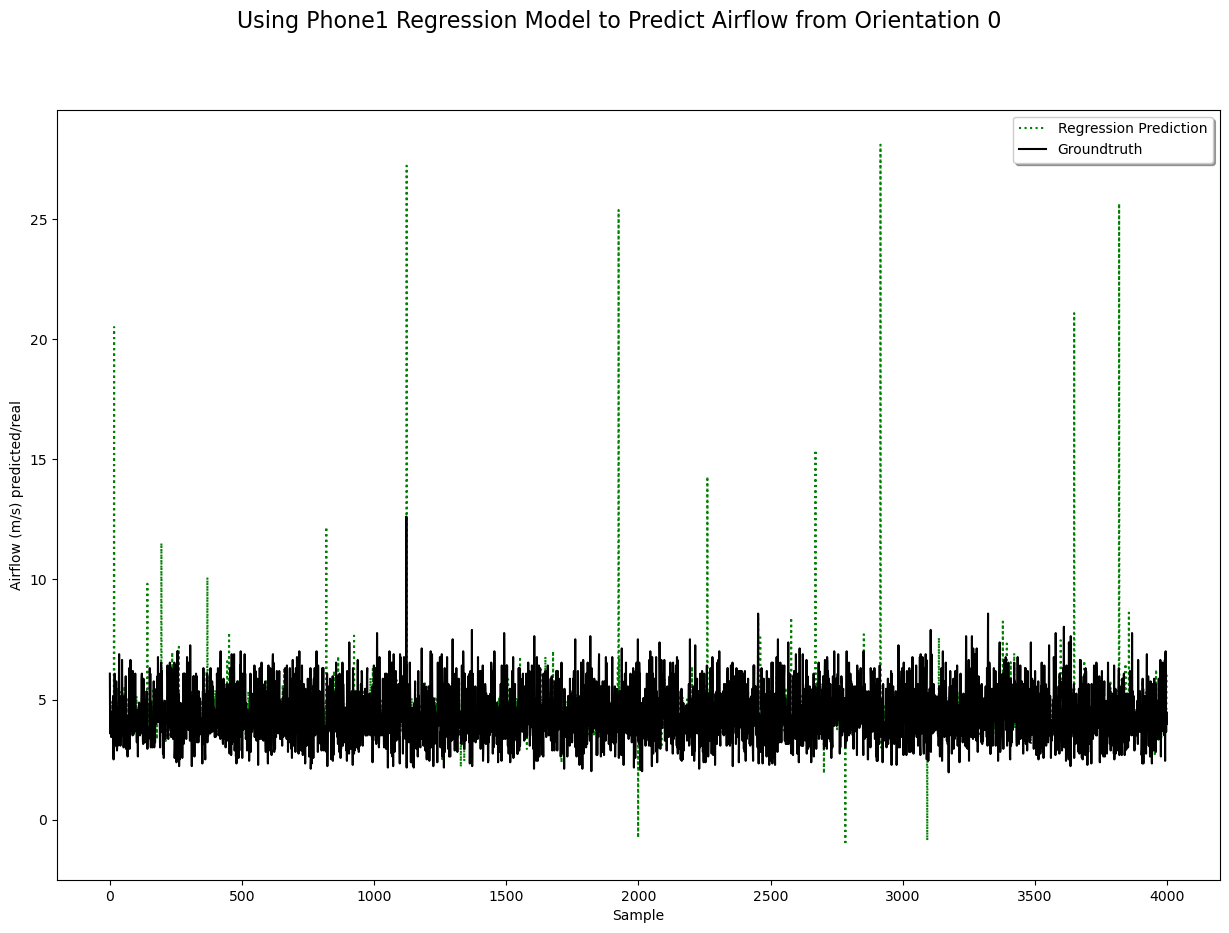

In [30]:
#Looking at predicting values from Orientation 0
df = df1.append([df4, df7])
data_mid = convert(df)
data_mid.shape

indices = np.random.choice(np.arange(data_mid.shape[0]), size=4000, replace=False, p=None)
    
X = data_mid[indices,:-1]
X = X[:, :9]
X.shape

y = data_mid[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from Orientation 0', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

Mean Squared Error:  1.9618622865922084


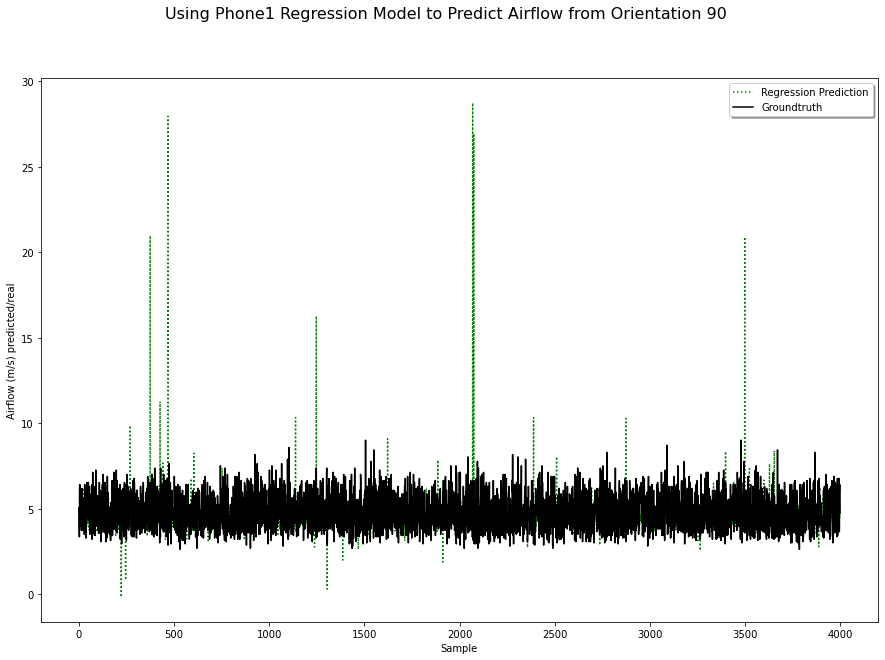

In [614]:
#Looking at predicting values from Orientation 90
df = df3.append([df6, df9])
data_mid = convert(df)
data_mid.shape

indices = np.random.choice(np.arange(data_mid.shape[0]), size=4000, replace=False, p=None)
    
X = data_mid[indices,:-1]
X = X[:, :9]
X.shape

y = data_mid[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from Orientation 90', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

Mean Squared Error:  5.631475748077811


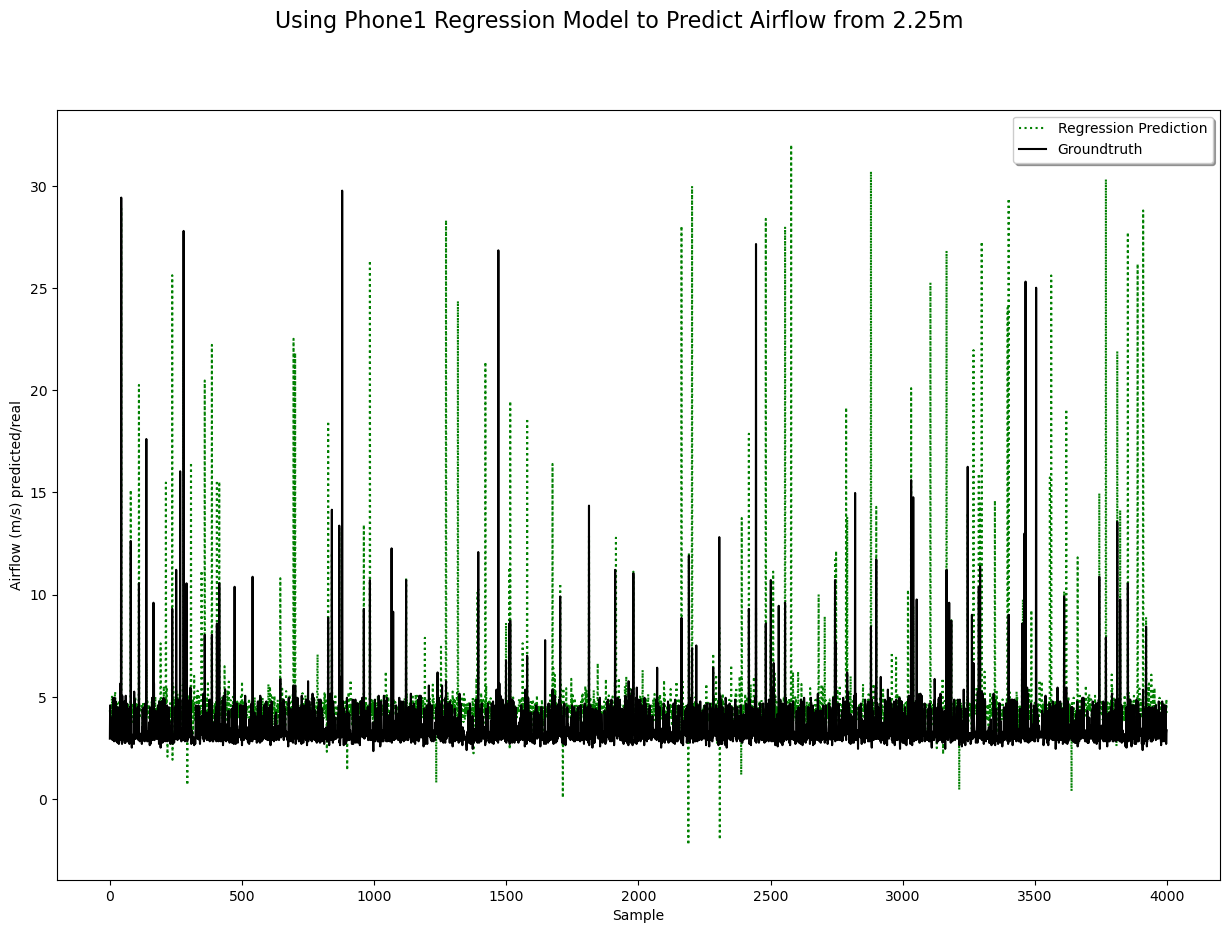

Mean Squared Error:  11.095444341254032
Mean Squared Error:  2.5720320546440707
Mean Squared Error:  2.5010560687936785
Mean Squared Error:  3.1104086580194483
Mean Squared Error:  4.612907600937307
[11.095444341254032, 2.5720320546440707, 2.5010560687936785, 3.1104086580194483, 4.612907600937307]


In [343]:
#Looking at predictions from 2.25m
data_dir = Path("./2.25m") 
df1 = pd.read_csv(data_dir / "fft_225_90_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df2 = pd.read_csv(data_dir / "fft_225_90_Vent2_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2.dropna()

df3 = pd.read_csv(data_dir / "fft_225_180_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = df3.dropna()

df4 = pd.read_csv(data_dir / "fft_225_0_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df4 = df4[df4['frequency'] != "clocktime"]
df4 = df4.dropna()

df = df1.append([df2])
df = convert(df)
df.shape

indices = np.random.choice(np.arange(df.shape[0]), size=4000, replace=False, p=None)
    
X = df[:,:-1]
X = X[indices, :9]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from 2.25m', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

for indices in [range(2000), range(2000,4000), range(4000,6000), range(6000,7000), range(7000,8000)]:
    X = df[:,:-1]
    X = X[indices, :9]
    X.shape

    y = df[indices, -1]
    y.shape

    print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))
    MSE_scores22.append(mean_squared_error(reg.predict(X), y))
    
print(MSE_scores22)

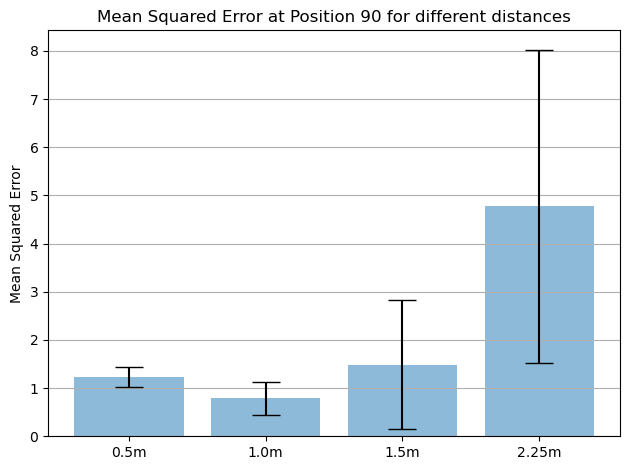

In [344]:
#ERROR BAR GRAPH CODE
# Calculate the average
five_mean = np.mean(MSE_scores05)
one_mean = np.mean(MSE_scores10)
onefive_mean = np.mean(MSE_scores15)
two_mean = np.mean(MSE_scores22)

# Calculate the standard deviation
five_std = np.std(MSE_scores05)
one_std = np.std(MSE_scores10)
onefive_std = np.std(MSE_scores15)
two_std = np.std(MSE_scores22)

# Define labels, positions, bar heights and error bar heights
labels = ['0.5m', '1.0m', '1.5m', '2.25m']
x_pos = np.arange(len(labels))
CTEs = [five_mean, one_mean, onefive_mean, two_mean]
error = [five_std, one_std, onefive_std, two_std]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel("Mean Squared Error")
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Mean Squared Error at Position 90 for different distances')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('Model3_error_bars_MSE_90.png')
plt.show()

Mean Squared Error:  4.618129202729777


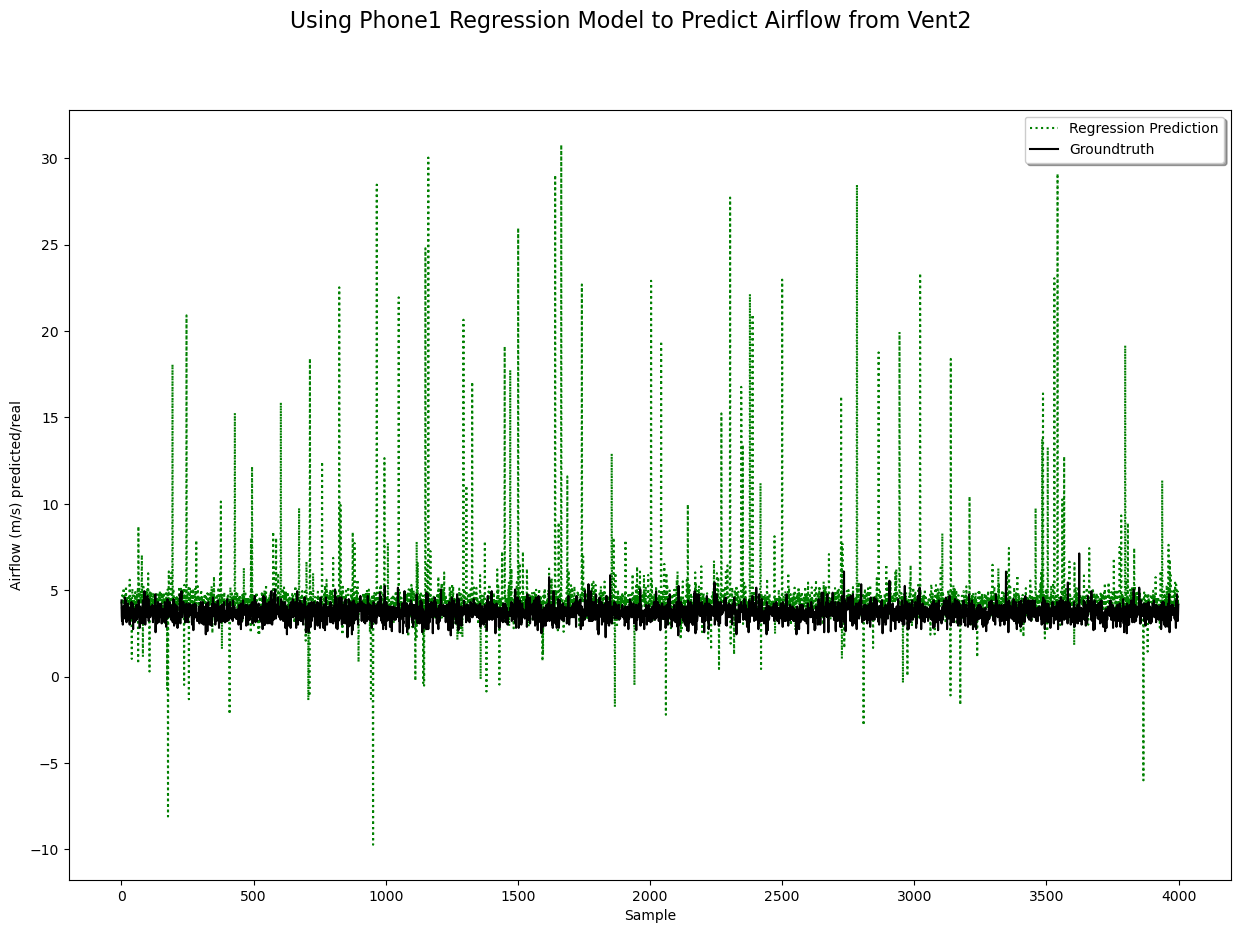

In [280]:
#Looking at predictions from Vent2
data_dir = Path("./Vent2") 
df1 = pd.read_csv(data_dir / "fft_100_0_Vent2_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df = df1
df = convert(df)
df.shape

indices = np.random.choice(np.arange(df.shape[0]), size=4000, replace=False, p=None)
    
X = df[:,:-1]
X = X[indices, :9]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from Vent2', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

Mean Squared Error:  5.731334492718763


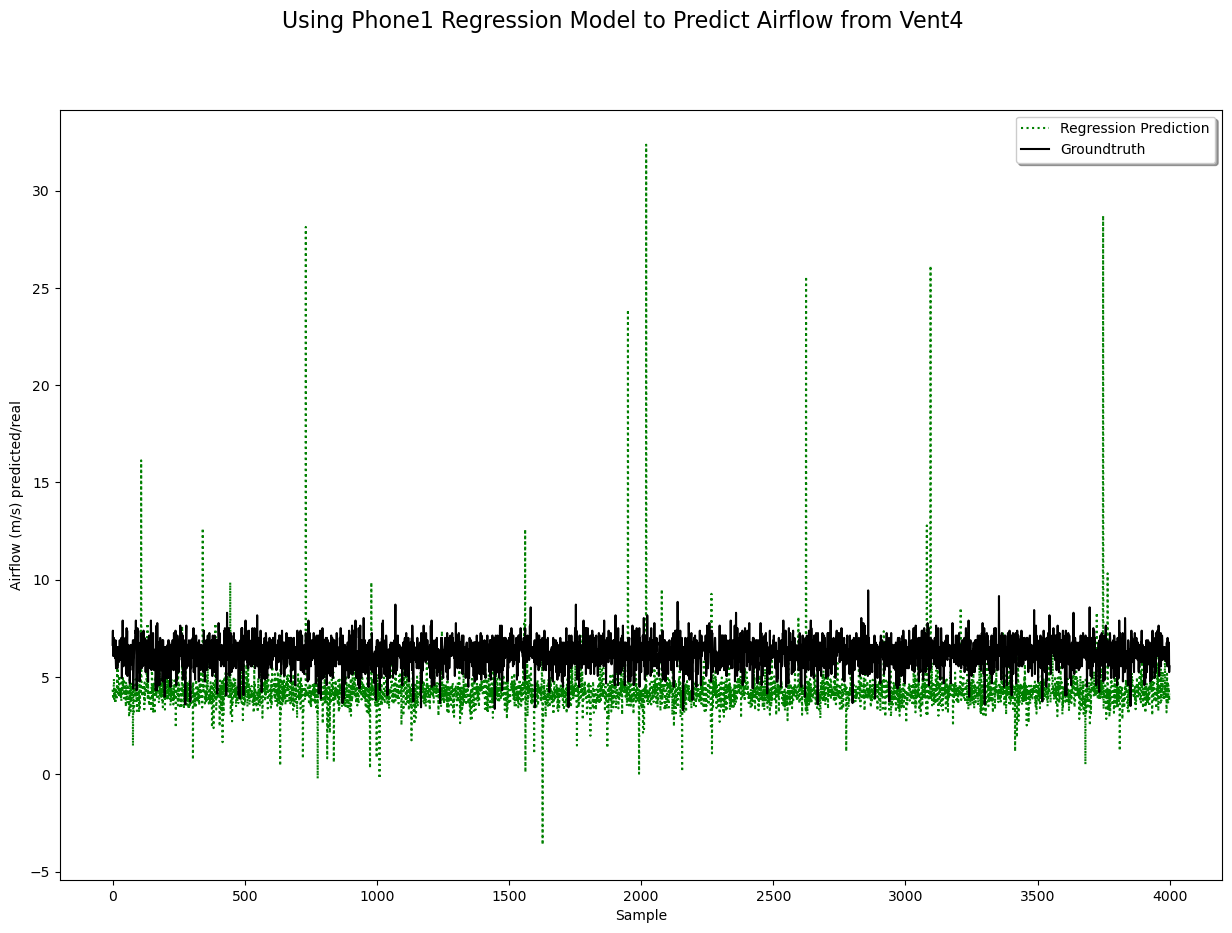

In [316]:
#Looking at predictions from Vent4
data_dir = Path("./Vent4 (CICS)") 
df1 = pd.read_csv(data_dir / "fft_100_0_Vent4_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df = df1
df = convert(df)
df.shape

indices = np.random.choice(np.arange(df.shape[0]), size=4000, replace=False, p=None)
    
X = df[:,:-1]
X = X[indices, :9]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from Vent4', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

Mean Squared Error:  11.35743590755962


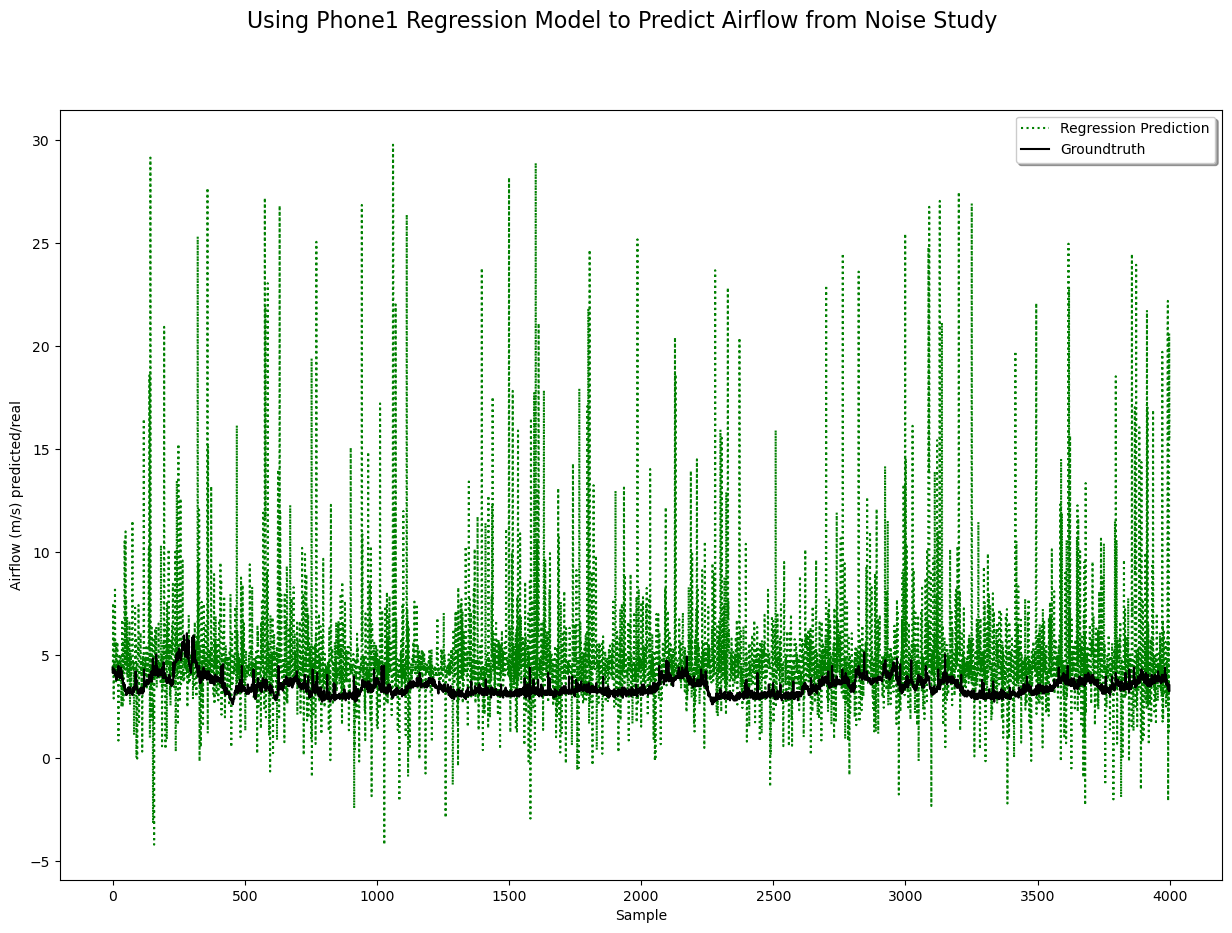

Mean Squared Error:  10.677271173675544
Mean Squared Error:  12.406957037562313
Mean Squared Error:  8.093637527589781
Mean Squared Error:  14.25187789141083


In [332]:
#Looking at predictions from Noise Study
data_dir = Path("./Noise-Study") 
df1 = pd.read_csv(data_dir / "fft_225_90_Vent1_50Vacuum.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df = df1
df = convert(df)
df.shape

indices = range(4000)
    
X = df[:,:-1]
X = X[indices, :9]
X.shape

y = df[indices, -1]
y.shape
    
print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Using Phone1 Regression Model to Predict Airflow from Noise Study', fontsize=16)
l0, = ax1.plot(reg.predict(X), 'g:')
l1, = ax1.plot(y, 'k-')
ax1.legend((l0, l1), ('Regression Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

for indices in [range(4000), range(4000, 8000), range(8000, 12000), range(12000, 16000), range(16000, 20000)]:
    X = df[:,:-1]
    X = X[indices, :9]
    X.shape

    y = df[indices, -1]
    y.shape

    print("Mean Squared Error: ", mean_squared_error(reg.predict(X), y))